In [1]:
import numpy as np
import os.path as osp
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.special import comb
from scipy.stats import sem, entropy
from matplotlib.ticker import FormatStrFormatter

# from models import LCALSTM
from utils.params import P
from data.ExpRun import process_cache
from data.StimGen import RNR_COND_DICT as cond_dict
from utils.io import build_log_path, load_ckpt, pickle_load_dict
from utils.constants import rnr_log_fnames

from analysis.utils import process_trial_type_info, extrat_trials
from analysis.behav import compute_predacc, compute_dks, get_baseline
from analysis.neural import compute_evidence, compute_roc, compute_auc_over_time
from plt_helper import plot_pred_acc_rcl, compute_summary_stats


sns.set(style='white', context='talk', palette='colorblind')

# 
log_root = '/tigress/qlu/logs/learn-hippocampus/log/'

In [2]:
def compute_cm_similarity(C_atp, V_atp, Scalar_atp, p): 
    # compute lstm smilarity between cell states vs. memories
    model_sim = [None] * n_trial_types
    for j in range(n_trial_types):
        model_sim[j] = compute_evidence(
            C_atp[j], V_atp[j],
            Scalar_atp[j][:, :, 0], Scalar_atp[j][:, :, 1], Scalar_atp[j][:, :, 2],
            p.net.recall_func, p.net.kernel
        )
    return model_sim

def compute_cm_similarity_rnr(model_sim, p, n_trials, memory_ids_atp): 
    # pre compute some vars
    n_mems = p.env.rnr.n_mvs - 1
    n_chunks = p.env.event_len//p.net.enc_size
    n_mems_total = n_chunks * n_mems
    
    # compute stats , NR trials
    model_sim_nr = np.mean(model_sim[1], axis=1)
    # compute, R trials
    model_sim_r = model_sim[0]
    model_sim_r_targ = np.zeros((p.env.event_len, n_chunks, n_trials[0]))
    model_sim_r_lure = np.zeros((p.env.event_len, (n_mems-1)*n_chunks, n_trials[0]))
    # separate target vs. lures
    for i in range(n_trials[0]):
        targ_id_ = int(memory_ids_atp[0][i])
        targ_ids = np.arange(targ_id_*n_chunks, (targ_id_+1)*n_chunks)
        lure_ids = list(set(range(n_mems_total)).difference(set(targ_ids)))
        model_sim_r_targ[:, :, i] = model_sim_r[:, targ_ids, i]
        model_sim_r_lure[:, :, i] = model_sim_r[:, lure_ids, i]

    # average if there are multiple targets, lures 
    model_sim_r_targ_ = np.mean(model_sim_r_targ, axis=1)    
    model_sim_r_lure_ = np.mean(model_sim_r_lure, axis=1)
    
    return model_sim_nr, model_sim_r_targ_, model_sim_r_lure_


In [3]:
'''fixed args'''

exp_name = 'multi_lure'
epoch_load = 300
n_epoch = 2000
n_mvs_rnr = 3
n_param = 11
n_hidden = 128
learning_rate = 1e-3

event_len = n_param + 1

In [14]:
penalty_list = [0, 8]
subj_ids = range(5)

n_ps = len(penalty_list)
n_subjs = len(subj_ids)

# penalty = 8
# subj_id = 0

# prealloc 
model_sim_list = [[None for _ in range(n_subjs)] for _ in range(n_ps)]

model_sim_nr_mu = [np.zeros((n_subjs, event_len)) for _ in range(n_ps)]
model_sim_r_targ_mu = [np.zeros((n_subjs, event_len)) for _ in range(n_ps)]
model_sim_r_lure_mu = [np.zeros((n_subjs, event_len)) for _ in range(n_ps)]


for i_p, penalty in enumerate(penalty_list):
    p = P(
        exp_name=exp_name,
        n_param=n_param,  penalty=penalty, n_hidden=n_hidden, lr=learning_rate,
    )
    p.env.rnr.n_mvs = n_mvs_rnr
    n_mems = p.env.rnr.n_mvs-1

    for i_s, subj_id in enumerate(subj_ids): 
        print(f'i_p: {i_p}, penalty = {penalty} | i_s: {i_s}, subj_id: {subj_id}')
        
        # create logging dirs
        log_path, log_subpath = build_log_path(subj_id, p, log_root=log_root, verbose=False)
        ckpt_template, save_data_fname = rnr_log_fnames(epoch_load, n_epoch)
        data_dict = pickle_load_dict(osp.join(log_subpath['rnr-data'], save_data_fname))
        # unpack data
        [C, V, Scalar, Vector] = data_dict['model_acts']
    #     [Y_encs, Y_rcl, Y_hat] = data_dict['data_labels']
        [memory_ids, trial_type_info] = data_dict['data_metadata']

        """split data"""
        # compute trial type info
        tt_info = process_trial_type_info(trial_type_info)
        trial_types, n_trial_types, trial_ids_set, n_trials = tt_info
        n_trials_total = np.sum(n_trials)
        trial_type_names = list(cond_dict.values())
#         print('number of trials per condition: ', n_trials)

        # split the data by trial type
        memory_ids_atp = [memory_ids[trial_ids_] for trial_ids_ in trial_ids_set]

        Scalar_atp = np.array([extrat_trials(Scalar, trial_ids_) for trial_ids_ in trial_ids_set])
        Vector_atp = np.array([extrat_trials(Vector, trial_ids_) for trial_ids_ in trial_ids_set])

        C_atp = [extrat_trials(C, trial_ids_) for trial_ids_ in trial_ids_set]
        V_atp = [extrat_trials(V, trial_ids_) for trial_ids_ in trial_ids_set]
        # Y_rcl_atp = [extrat_trials(Y_rcl, trial_ids_) for trial_ids_ in trial_ids_set]

        # Y_encs = [[Y_encs[i][m].data.numpy() for m in range(n_mems)] for i in range(n_trials_total)]
        # Y_encs_atp = np.squeeze([extrat_trials(Y_encs, trial_ids_) for trial_ids_ in trial_ids_set])

        # Y_hat_atp = np.array([extrat_trials(Y_hat, trial_ids_) for trial_ids_ in trial_ids_set])

        # predacc_atp = [compute_predacc(Y_rcl_atp[j], Y_hat_atp[j])[:,:-1] for j in range(n_trial_types)]
        # dks_atp = [compute_dks(Y_hat_atp[j])[:,:-1] for j in range(n_trial_types)]

        # compute cell - mem similarity
        model_sim_list[i_p][i_s] = compute_cm_similarity(C_atp, V_atp, Scalar_atp, p)
        
        # split by trial type x memory type
        model_sim_nr, model_sim_r_targ, model_sim_r_lure = compute_cm_similarity_rnr(
            model_sim_list[i_p][i_s], p, n_trials, memory_ids_atp
        )
        # NR
        model_sim_nr_mu[i_p][i_s], _ = compute_summary_stats(model_sim_nr, axis=1)
        # R
        model_sim_r_targ_mu[i_p][i_s], _ = compute_summary_stats(model_sim_r_targ, axis=1)
        model_sim_r_lure_mu[i_p][i_s], _ = compute_summary_stats(model_sim_r_lure, axis=1)
        
print('number of trials per condition: ', n_trials)

i_p: 0, penalty = 0 | i_s: 0, subj_id: 0
i_p: 0, penalty = 0 | i_s: 1, subj_id: 1
i_p: 0, penalty = 0 | i_s: 2, subj_id: 2
i_p: 0, penalty = 0 | i_s: 3, subj_id: 3
i_p: 0, penalty = 0 | i_s: 4, subj_id: 4
i_p: 1, penalty = 8 | i_s: 0, subj_id: 0
i_p: 1, penalty = 8 | i_s: 1, subj_id: 1
i_p: 1, penalty = 8 | i_s: 2, subj_id: 2
i_p: 1, penalty = 8 | i_s: 3, subj_id: 3
i_p: 1, penalty = 8 | i_s: 4, subj_id: 4
number of trials per condition:  [510, 510]


In [15]:
'''plot params'''
dpi = 150
ci_val = 99
n_se = 2
alpha_val = .05
# target-lure pallete
tl_pals = sns.color_palette('colorblind', n_colors=4, desat=1)[-n_trial_types:]
# trial type params
tt_pals = sns.color_palette(n_colors=n_trial_types)

In [16]:
# model_sim_list[1]

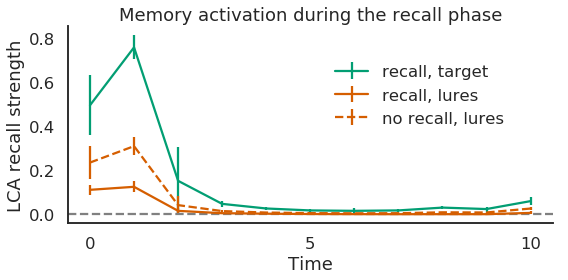

In [17]:
i_p = 0

# compute summary over subjs 
model_sim_nr_mu_, model_sim_nr_er_ = compute_summary_stats(
    model_sim_nr_mu[i_p], axis=0, n_se=n_se)
model_sim_r_targ_mu_, model_sim_r_targ_er_ = compute_summary_stats(
    model_sim_r_targ_mu[i_p], axis=0, n_se=n_se)
model_sim_r_lure_mu_, model_sim_r_lure_er_ = compute_summary_stats(
    model_sim_r_lure_mu[i_p], axis=0, n_se=n_se)    

'''plot'''
f, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.errorbar(
    range(p.env.n_param), 
    y=model_sim_r_targ_mu_[:-1], yerr=model_sim_r_targ_er_[:-1],
    color=tl_pals[0])
ax.errorbar(
    range(p.env.n_param), 
    y=model_sim_r_lure_mu_[:-1], yerr=model_sim_r_lure_er_[:-1],
    color=tl_pals[1])
ax.errorbar(
    range(p.env.n_param), 
    y=model_sim_nr_mu_[:-1], yerr=model_sim_nr_er_[:-1],
    linestyle='--', color=tl_pals[1])
f.legend(['recall, target', 'recall, lures', 'no recall, lures'],
         frameon=False, bbox_to_anchor=(.9, .8))

ax.axhline(0, color='grey', linestyle='--')

ax.set_title('Memory activation during the recall phase')
ax.set_ylabel('LCA recall strength')
ax.set_xlabel('Time')

ax.set_xticks(np.arange(0, p.env.n_param, 5))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

sns.despine()
f.tight_layout()

# img_name = f'e{epoch_load}-rmdnd{lesion_recall}-recall-str.png'
# f.savefig(osp.join(img_path, img_name), bbox_inches='tight', dpi=dpi)

In [18]:
# # treating the activation profile as a probability distribution
# # compute expectation

# pmf = model_sim_r_targ_mu_ / np.sum(model_sim_r_targ_mu_)
# rt = np.sum(np.arange(p.env.event_len) * pmf)
# print(rt)

In [23]:
'''signal detction metric - max score, compare trial types
'''

def compute_max_score_perfm(
    model_sim_, 
    n_bins = 100, histrange = (0, 1)
):
    # compute max scores
    max_acts = np.max(model_sim_, axis=2)

    # compute AUC 
    tprs, fprs, auc = compute_auc_over_time(
        max_acts[1], max_acts[0], n_bins=n_bins, histrange=histrange
    )
    tprs, fprs, auc = np.array(tprs), np.array(fprs), np.array(auc)
    return tprs, fprs, auc

# compute max score performance metrices for all penalty level 
tprs = [[None for _ in range(n_subjs)] for _ in range(n_ps)]
fprs = [[None for _ in range(n_subjs)] for _ in range(n_ps)]
auc = [[None for _ in range(n_subjs)] for _ in range(n_ps)]

for i_p, penalty in enumerate(penalty_list):
    for i_s, subj_id in enumerate(subj_ids): 
        tfa = compute_max_score_perfm(model_sim_list[i_p][i_s])
        tprs[i_p][i_s], fprs[i_p][i_s], auc[i_p][i_s] = tfa

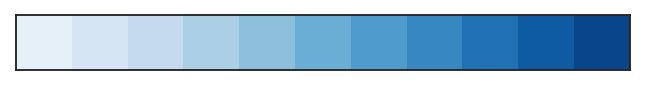

In [46]:
sns.palplot(cur_pal)

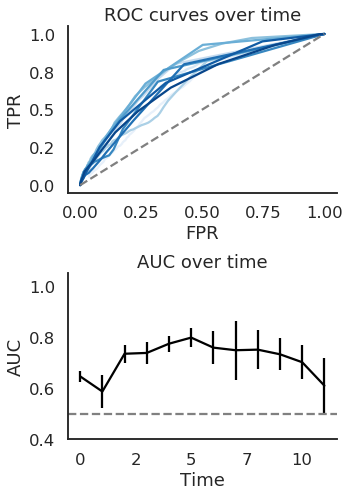

In [37]:
i_p = 1

fprs_mu = np.mean(fprs[i_p],axis=0)
tprs_mu = np.mean(tprs[i_p],axis=0)
auc_mu, auc_eb = compute_summary_stats(auc[i_p],axis=0)

cur_pal = sns.color_palette('Blues', n_colors=n_param)

f, axes = plt.subplots(2, 1, figsize=(5, 7))
for t in range(n_param):
    axes[0].plot(fprs_mu[t], tprs_mu[t], color=cur_pal[t])
axes[0].set_xlabel('FPR')
axes[0].set_ylabel('TPR')
axes[0].set_title('ROC curves over time')
axes[0].plot([0, 1], [0, 1], linestyle='--', color='grey')

axes[1].errorbar(
    x=range(p.env.event_len), y=auc_mu, yerr=auc_eb, 
    color='black'
)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('AUC')
axes[1].set_title('AUC over time')
# axes[1].set_title('AUC over time, mean = %.2f' % (np.mean(auc)))
axes[1].axhline(.5, linestyle='--', color='grey')
axes[1].set_ylim([.4, 1.05])

for ax in axes:
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axes[1].xaxis.set_major_formatter(FormatStrFormatter('%d'))
f.tight_layout()
sns.despine()
# img_name = f'e{epoch_load}-auc-ms.png'
# f.savefig(osp.join(img_path, img_name), bbox_inches='tight', dpi=dpi)

#sns.palplot(cur_pal)

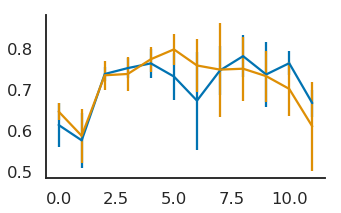

In [38]:
f, ax = plt.subplots(1, 1, figsize=(5, 3))

for i_p, penalty in enumerate(penalty_list):
    auc_mu, auc_eb = compute_summary_stats(auc[i_p],axis=0)
    ax.errorbar(
        x=range(p.env.event_len), y=auc_mu, yerr=auc_eb, 
    )
sns.despine()

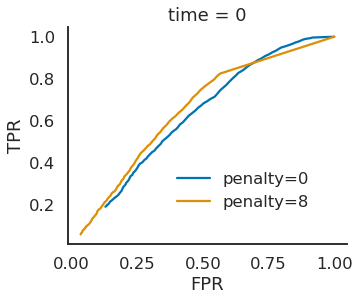

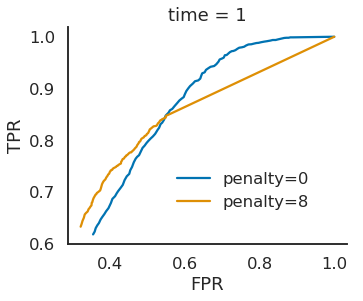

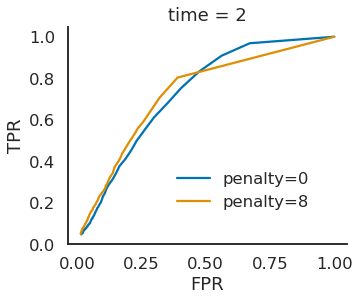

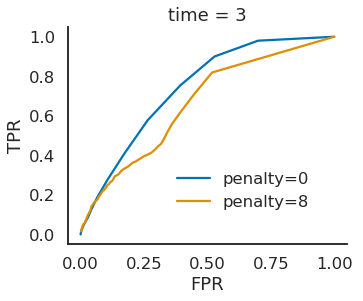

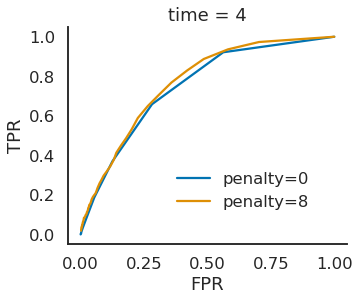

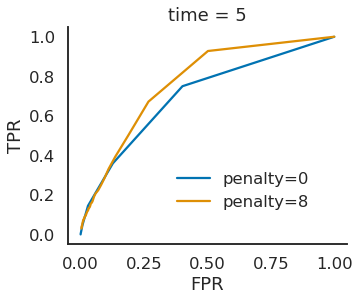

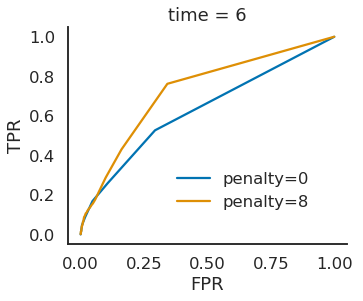

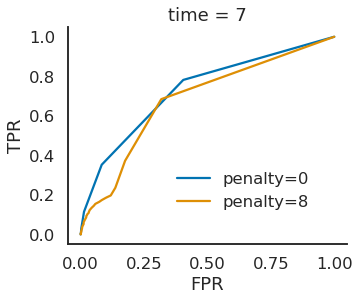

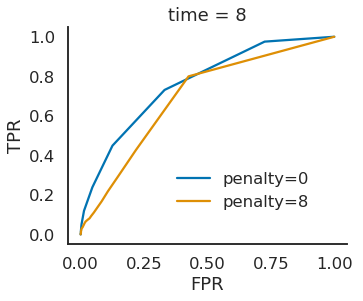

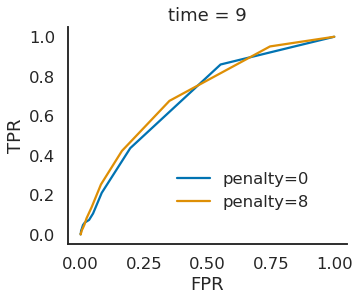

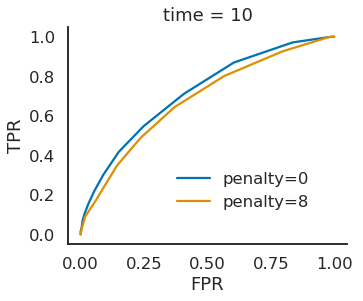

In [68]:
fprs_mu_ap = [np.mean(fprs[i_p],axis=0) for i_p in range(n_ps)]
tprs_mu_ap = [np.mean(tprs[i_p],axis=0) for i_p in range(n_ps)]

for t in range(n_param):
    f, ax = plt.subplots(1, 1, figsize=(5, 4))
    for i_p in range(n_ps):
        ax.plot(
            fprs_mu_ap[i_p][t], tprs_mu_ap[i_p][t], 
            label=f'penalty={penalty_list[i_p]}'
        )
    f.legend(frameon=False, bbox_to_anchor=(.9,.5))
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.set_title(f'time = {t}')
#     ax.plot([0, 1], [0, 1], linestyle='--', color='grey')
    sns.despine()

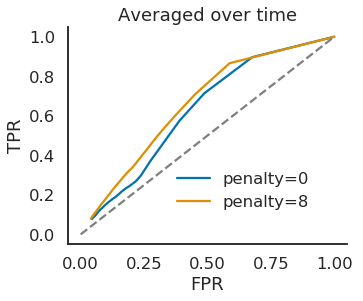

In [65]:
f, ax = plt.subplots(1, 1, figsize=(5, 4))

for i_p in range(n_ps):
    ax.plot(
        np.mean(fprs_mu_ap[i_p].T,axis=1), np.mean(tprs_mu_ap[i_p].T,axis=1),
        label=f'penalty={penalty_list[i_p]}',
    );

f.legend(frameon=False, bbox_to_anchor=(.9,.5))
ax.set_title('Averaged over time')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.plot([0, 1], [0, 1], linestyle='--', color='grey')
sns.despine()